## Import libs and custom vars

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from libs.utils import find_penalty, return_outcome, check_element, add_labels, find_range
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import datetime
from numba import jit
import pycountry_convert as pc


<b>L'obbiettivo del progetto è la costruzione di un modello per predizioni di match internazionali</b>


<ul>
    <li>Ci sono alcuni nomi di squadre che sono cambiate nel tempo, uniformizza </li>
    <li>Shootouts è il db dei penalty, quindi bisogna manipolare il dataset per vedere chi vince alla fine quella partita</li>
</ul>

### Descrizione del dataset


Il Dataset contiene 42483 risultati di partite di calcio internazionale maschile. In particolare, sono incluse sia le partite ufficiali di tutte le competizioni: dalle amichevoli alla coppa del mondo eccetto i Giochi Olimpici o le partite dove almeno una delle due squadre era la squadra B o U-23. Inoltre, il dataset presenta un ulteriore file che contiene 432 risultati di partite terminate con i calci di rigore, <u>che non considereremo in quanto il modello dovrà predirre il risultato come: 'Home win', 'Draw', 'Away win'.</u>

In [2]:
dst_df = pd.read_csv('dataset/results.csv');

print("Null values:", dst_df.isnull().values.any(), "| shape:", dst_df.shape)
print("***"*15)
print(dst_df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Preparazione del daset
- campo date formattato in anno
- colonna 'risultato'
- converto home_score e away_score in float

In [3]:
dst_df = dst_df.astype({"home_score": float, "away_score": float})

dst_df['outcome'] = None
dst_df['day'] = None
dst_df['month'] = None
dst_df['year'] = None

date_separator = ', '

counter = 0
for i in range(0, len(dst_df)):
    counter = counter + 1
    print('*** Processing %d/%d ***' % (counter, len(dst_df)), end='\r')

    # Formatto i nomi dei continenti per standardizzarli al dataset FIFA usato dopo
    if(dst_df.loc[i]['country'] == 'United States'):
        dst_df.at[i, 'country'] = 'USA'

    # estraggo dati necessari dalla data
    row_date = datetime.date.fromisoformat(dst_df.iloc[i]['date'])
    dst_df.at[i, 'day'] = row_date.strftime('%d') + date_separator + row_date.strftime('%A')
    dst_df.at[i, 'month'] = row_date.strftime('%B')
    dst_df.at[i, 'year'] = int(row_date.strftime('%Y'))

    # calcolo il risultato della partita
    dst_df.at[i, 'outcome'] = return_outcome(dst_df.iloc[i]['home_score'], dst_df.iloc[i]['away_score'])

    # deprecato
    # if(dst_df.iloc[i]['outcome'] == 'D'):
    #     dst_df.at[i, 'outcome'] = find_penalty(data['results'].iloc[i], data['shootouts'], sht_len - 1)

dst_df.drop(labels=['date'], axis=1, inplace=True)
dst_df.to_csv('dataset/dataset.csv')

### To do:
1. <s>Statistica descrittiva</s> DOING
2. PMF sui dati degli anni / approssimaziona a CMF (?)
3. Barplot su:
    - goal fatti
    - sul numero di partite per continente
4. Scatterplot
    - sui goal ?
    - dei risultati di outcome D/H/A (?)

Da vedere come inserire:
- comparare il numero di partite per nazione
- score per games?

Modelli:
    - Regressione logistica
    - Alberi decisionali
    - o...?

Da inserire (?)
    - FIFa ranking per elaborazione modello
        - regole del ranking
        - spiegare funzionamento
        - aggiungere 'ranking' in base alla data
    
Aggiuntivi da implementare via facendo + descrizione
- Eliminare i paesi che hanno cambiato nome/pulizia dataset
- Riduzione delle dimensionalità
    - per il calcolo del modello considera solo se le partite sono state giocate in campo neutrale

In [2]:
dst = pd.read_csv('dataset/dataset.csv')
dst.drop(labels=['Unnamed: 0', 'city'], axis=1, inplace=True)

dst.head()

,home_team,away_team,home_score,away_score,tournament,country,neutral,outcome,day,month,year
0,Scotland,England,0.0,0.0,Friendly,Scotland,False,Draw,"30, Saturday",November,1872
1,England,Scotland,4.0,2.0,Friendly,England,False,Home,"08, Saturday",March,1873
2,Scotland,England,2.0,1.0,Friendly,Scotland,False,Home,"07, Saturday",March,1874
3,England,Scotland,2.0,2.0,Friendly,England,False,Draw,"06, Saturday",March,1875
4,Scotland,England,3.0,0.0,Friendly,Scotland,False,Home,"04, Saturday",March,1876


### 1. Statistica descrittiva - Distribuzione dei dati

Descrizione del dataset
1. Numero di partie per anno
2. Numero di partie per anno per contiente
3. Numero di goal per anno (? / scatterplot)
4. Numero di vittorie (scatterplot)


##### Numero di partite per anno:

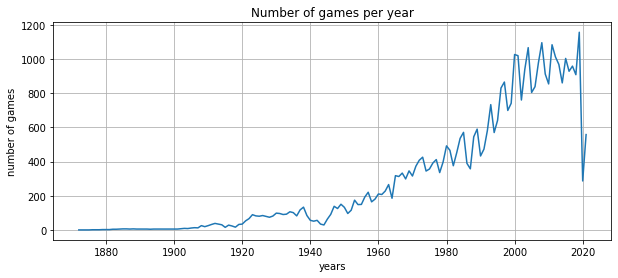

In [5]:
#### inserire prima guerra mondiale, seconda e covid

mpy = dst['year'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')
plt.plot(mpy)

plt.grid()
plt.show()

##### Numero di partite giocate per anno da ogni continente

In [3]:
# continente in cui è stato disputato il match
dst['continent'] = ''

# mi ricavo le confederazioni delle nazionali dal dataset FIFA
dst_fifa = pd.read_csv('dataset/fifa_ranking-2021-05-27.csv')
dst_fifa.drop(labels=['rank', 'rank_date', 'rank_change', 'total_points', 'previous_points', 'id'], axis=1, inplace=True)
dst_fifa.drop_duplicates(subset="country_full", keep="first", inplace=True)

# so già a prescindere che ci saranno delle nazioni non riconosciute
df_nocontinent_found = pd.DataFrame(columns=dst.columns)

index_mismatches_dst = []

for i in range(0, len(dst)):
    if( dst_fifa[(dst_fifa.country_full == dst.iloc[i]['country'])]['confederation'].values.__len__() == 1 ):
        confederation = dst_fifa[(dst_fifa.country_full == dst.iloc[i]['country'])]['confederation'].values[0]
        
        if confederation in "CONCACAF":
            continent = "America"

        if confederation in "CONMEBOL":
            continent = "America"

        if confederation == "UEFA":
            continent = "Europe"

        if(confederation == "AFC"):
            continent = "Asia"
        
        if(confederation == "CAF"):
            continent = "Africa"

        if(confederation == "OFC"):
            continent = "Oceania"

        dst.at[i, 'continent'] = continent
    else:
            current = dst.iloc[i]['country']

            if (current == 'Bohemia'
                    or current == 'Soviet Union'
                    or current == 'Irish Free State'
                    or current == 'German DR'
                    or current == 'Saarland'
                    or current == 'Jersey'
                    or current == 'Northern Cyprus'
                    or current == 'Isle of Man'
                    or current == 'Guernsey'
                    or current == 'Bohemia and Moravia'
                    or current == 'Monaco' ):
                dst.at[i, 'continent'] = 'Europe'

            elif (dst.iloc[i]['country'] == 'British Guyana'
                    or current == 'Netherlands Guyana'
                    or current == 'French Guiana'
                    or current == 'Saint Kitts and Nevis'
                    or current == 'Éire'
                    or current == 'Guadeloupe'
                    or current == 'Martinique'
                    or current == 'Saint Lucia'
                    or current == 'Saint Vincent and the Grenadines'
                    or current == 'Saint Martin'
                    or current == 'United States Virgin Islands'
                    or current == 'Sint Maarten'
                    or current == 'Greenland' ):
                dst.at[i, 'continent'] = 'America'

            elif (dst.iloc[i]['country'] == 'Manchuria'
                    or current == 'Iran'
                    or current == 'Ceylon'
                    or current == 'Burma'
                    or current == 'Malaya'
                    or current == 'South Korea'
                    or current == 'Vietnam Republic'
                    or current == 'United Arab Republic'
                    or current == 'North Korea'
                    or current == 'Vietnam DR'
                    or current == 'Taiwan'
                    or current == 'Kyrgyzstan'
                    or current == 'East Timor'
                    or current == 'Brunei'
                    or current == 'Yemen DPR'
                    or current == 'Yemen AR' ):
                dst.at[i, 'continent'] = 'Asia'

            elif (dst.iloc[i]['country'] == 'Northern Rhodesia'
                    or current == 'Tanganyika'
                    or current == 'French Somaliland'
                    or current == 'Belgian Congo'
                    or current == 'Southern Rhodesia'
                    or current == 'Réunion'
                    or current == 'Zanzibar' 
                    or current == 'Gold Coast'
                    or current == 'Nyasaland'
                    or current == 'Dahomey'
                    or current == 'Mali Federation'
                    or current == 'Ivory Coast'
                    or current == 'DR Congo'
                    or current == 'Upper Volta'
                    or current == 'Eswatini'
                    or current == 'Zaïre'
                    or current == 'Cape Verde'
                    or current == 'Mayotte'
                    or current == 'Portuguese Guinea'
                    or current == 'Rhodesia' ):
                dst.at[i, 'continent'] = 'Africa'

            elif (dst.iloc[i]['country'] == 'French Polynesia'
                    or current == 'New Hebrides'
                    or current == 'Lautoka'
                    or current == 'Northern Mariana Islands'
                    or current == 'Micronesia'
                    or current == 'Palau'
                    or current == 'Western Samoa' ):
                dst.at[i, 'continent'] = 'Oceania'

            else:
                print("Exception at row: %d" % i)
                df_nocontinent_found = df_nocontinent_found.append(dst.iloc[i])


if(df_nocontinent_found.__len__() == 0):
    print("All rows are correctly updated")
else:
    # per analizzare meglio salvo il csv
    df_nocontinent_found.to_csv('output.csv')


# salvo per evitare di doverlo ricreare se faccio errori
dst.to_csv('dataset/dataset_continent.csv')

All rows are correctly updated


In [109]:
# per fare il grafo devo utilizzare degli array con le stesse dimensioni
# anche per quegli anni in cui i contiennti non hanno giocato a calcio 
# ----- FIXA COME LO DICI -------

def fix_continent_matches(all_years, df):
    not_played_years = set(years) - (set(all_years).intersection(df.year.values))

    # df = pd.concat([pd.DataFrame([i, 0], columns=['year', 'matches']) for i in not_played_years], ignore_index=True)

    for i in not_played_years:
        df = df.append({'year': i, 'matches': 0}, ignore_index=True)

    df = df.sort_values(by='year').reset_index().drop(columns=['index'])

    return df

In [110]:
dst_continent_ = pd.read_csv('dataset/dataset_continent.csv')
dst_continent_.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

dst_continent_reduced = dst_continent_.groupby(['continent','year']).size().to_csv('output.csv')
dst_continent_reduced = pd.read_csv('output.csv')
dst_continent_reduced = dst_continent_reduced.sort_values(by='year').reset_index().drop(columns=['index']).rename(columns={'0': 'matches'})

if dst_continent_.__len__() == dst_continent_reduced['matches'].sum():
    print("Groupby eseguito correttamente")


years = dst_continent_reduced['year'].drop_duplicates().to_numpy()

africa = dst_continent_reduced[dst_continent_reduced['continent'] == 'Africa' ].reset_index().drop(columns=['continent', 'index'])
europe = dst_continent_reduced[dst_continent_reduced['continent'] == 'Europe'].reset_index().drop(columns=['continent', 'index'])
america = dst_continent_reduced[dst_continent_reduced['continent'] == 'America'].reset_index().drop(columns=['continent', 'index'])
oceania = dst_continent_reduced[dst_continent_reduced['continent'] == 'Oceania'].reset_index().drop(columns=['continent', 'index'])
asia = dst_continent_reduced[dst_continent_reduced['continent'] == 'Asia'].reset_index().drop(columns=['continent', 'index'])

africa  =  fix_continent_matches(years, africa)
europe  =  fix_continent_matches(years, europe)
america =  fix_continent_matches(years, america)
oceania =  fix_continent_matches(years, oceania)
asia     = fix_continent_matches(years, asia)


if (len(africa) == len(europe) == len(america) == len(oceania) == len(asia) ):
    print("Tutti i df hanno lo stesso numero di righe")

Groupby eseguito correttamente
Tutti i df hanno lo stesso numero di righe


In [114]:
print(africa.matches.values)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   2   0   1   1   2   1   2   0   1   2   1   1   1   1   1   1   1   1
   1   2   3   8  10   7  17   8   9  14  19  10  13  17  15  12  37  28
  40  55  38  63  57  83  62  73  65  74  91  82  64  73 109  87  76  96
 132 130 112 157 185 147 102 118 126 139 123 144 146 159 131 157 167 181
 150 166 271 219 183 230 197 170 175 196 234 184 220 198 223 259 199 290
 201 255 136 288  17  97]


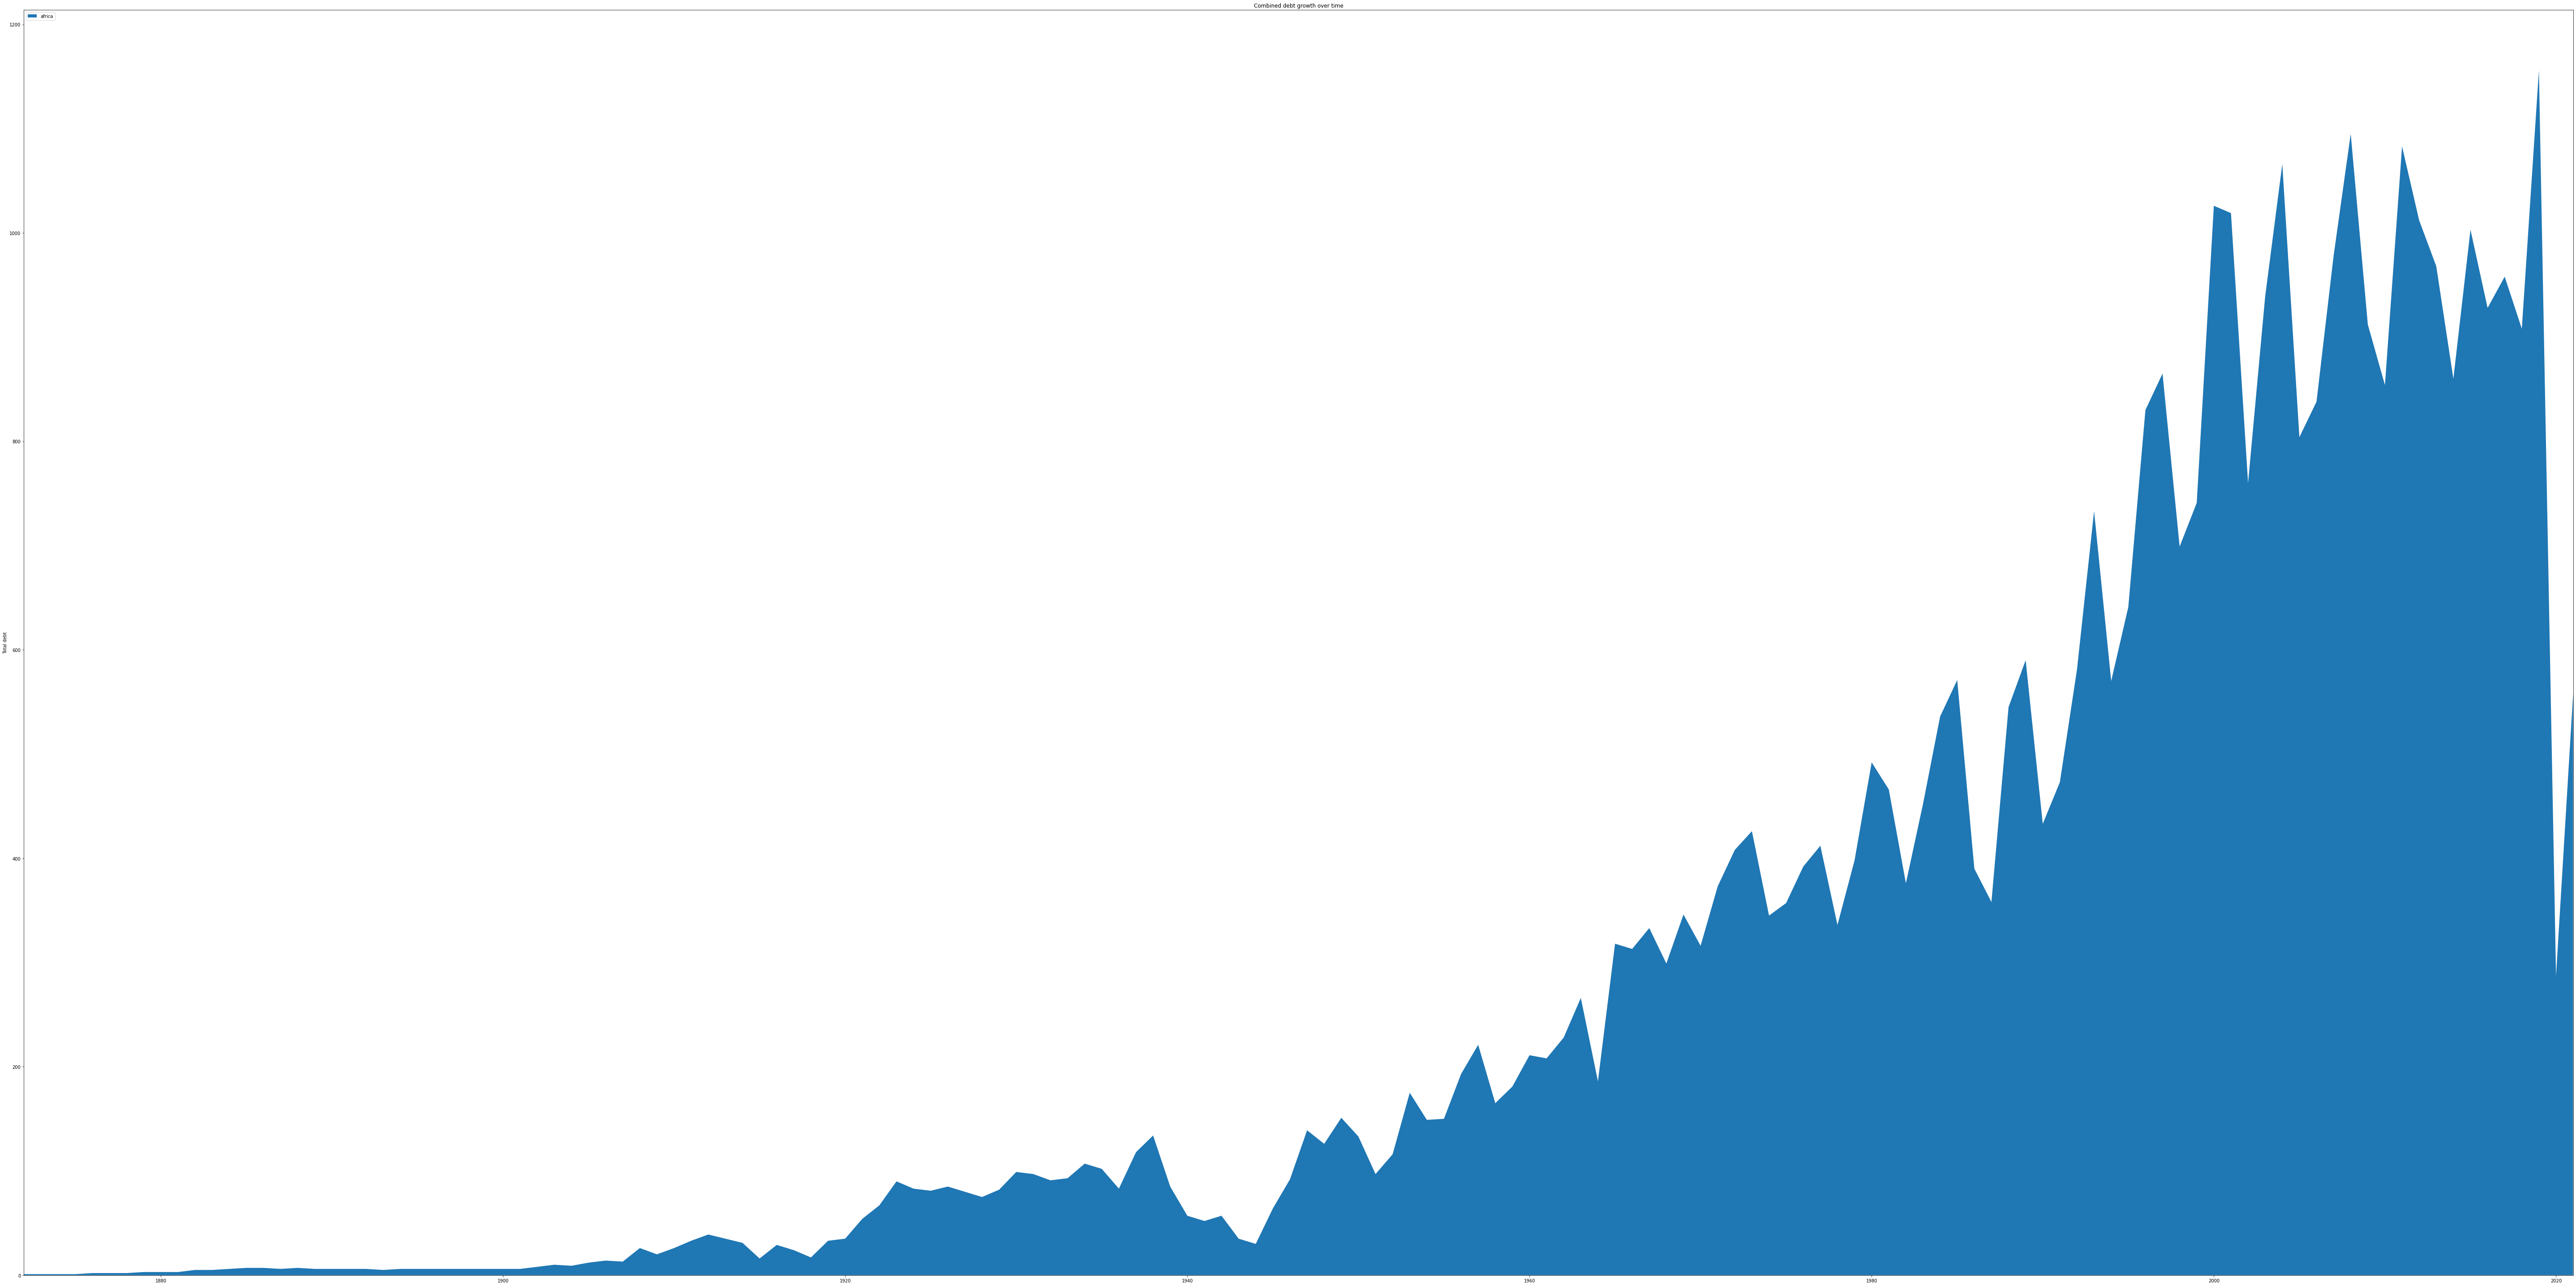

In [117]:
fig, ax = plt.subplots(figsize=(80, 40))
ax.stackplot(years, africa.matches.values + europe.matches.values + america.matches.values + oceania.matches.values + asia.matches.values , labels=['africa', 'Europe', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=years[0], xmax=years[-1])
fig.tight_layout()